<a href="https://colab.research.google.com/github/desstaw/Shortcut_Learning/blob/main/ISIC_224_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchextractor

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
import torch
import sys
import numpy as np
import pickle as pkl
from os.path import join as oj
from datetime import datetime
import torch.optim as optim
import os
from torch.utils.data import TensorDataset, ConcatDataset
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score
import argparse
from PIL import Image
from tqdm import tqdm
from torch import nn
from numpy.random import randint
import torchvision.models as models
import time
import copy
import gc
import json
import pandas as pd
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image

## Mount Google Drive and create paths for directories


In [4]:
from google.colab import drive
drive.mount("/content/drive")
dir_path = "/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224"
#dir_path = "/content/drive/MyDrive/Projects/ISIC_224"

Mounted at /content/drive


In [5]:
model_path = oj(dir_path, "models", "initial_classifier")
model_training_path = oj(model_path, "training_224")
data_path = oj(dir_path, "data")

not_cancer_path = oj(data_path, "processed", "no_cancer_224")
cancer_path = oj(data_path, "processed", "cancer_224")

### Arguments for training

1. Mean and Standard Deviation: These are normalization parameters used for preprocessing images. They are often used in computer vision tasks to scale pixel values to a common range.

2. Device Configuration: It determines whether the code should run on CPU or GPU (cuda) based on the availability of CUDA support. CUDA is a parallel computing platform and application programming interface model created by NVIDIA. If CUDA is available, the code will run on the GPU; otherwise, it will use the CPU.

3. Model Initialization: It loads a pre-trained VGG16 model from torchvision.models, modifies the last layer of the classifier to output 2 classes (it seems to be for some kind of classification task), moves the model to the specified device (CPU or GPU), and sets the parameters to update during training (in this case, only the parameters of the classifier).

**The VGG16 model has the following structure:**
1. Several convolutional layers followed by max-pooling layers.
2. Three fully connected (dense) layers at the end, which constitute the classifier.
Classifier Part of VGG16


**The classifier part of the original VGG16 model is designed as follows:**

1. First Fully Connected Layer: 4096 neurons, which take the flattened output from the last convolutional layer.
2. Second Fully Connected Layer: 4096 neurons.
3. Final Fully Connected Layer: The number of neurons corresponds to the number of output classes, which is 1000 for ImageNet.

In [6]:
import numpy as np
import argparse
import torch
import torchvision.models as models
import torch.nn as nn

mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])

# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 16
        self.epochs = 10
        self.lr = 0.00001
        self.momentum = 0.9
        self.seed = 42
        self.regularizer_rate = 0.0

args = Args()

regularizer_rate = args.regularizer_rate
num_epochs = args.epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(args.seed)
model = models.vgg16(pretrained=True)
#changing nn.Linear(4096, 1000) to nn.Linear(4096, 2) as vgg was trained on imagenet with 1000 classes originally
model.classifier[-1] = nn.Linear(4096, 2)
model = model.to(device)
params_to_update = model.classifier.parameters()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 196MB/s]


###Clean up the image directories



*   Remove empty images
*   Remove duplicates which appear in a new folder but not the original.
*   Ensure image sizes are all 224x224



In [7]:
def clean_up_empty_files(path):
    list_files= os.listdir(path)
    num_files = len(list_files)
    for i in tqdm(range(num_files)):
        if os.path.getsize(oj(path, list_files[i])) < 100:
            os.remove(oj(path, list_files[i]))
            print("File " + str(i) + "deleted!")
'''
def clean_up_duplicates(path1, path2):
    newfiles = os.listdir(path1)
    oldfiles = os.listdir(path2)
    diff = [f for f in newfiles if f not in oldfiles]
    for i in tqdm(diff):
        os.remove(oj(path1, i))
        print("File " + str(i) + "deleted!")

def check_img_sizes(path):
    list_files= os.listdir(path)
    num_files = len(list_files)
    for i in tqdm(range(num_files)):
        im = Image.open(oj(path, list_files[i]))
        if im.width != 224 or im.height != 224:
            print(list_files[i])
'''
# clean_up_empty_files(cancer_path)
# clean_up_empty_files(not_cancer_path)

# newpath = oj(data_path, "no_cancer_224_inpainted")
# oldpath = oj(data_path, "processed", "no_cancer_224")
# clean_up_duplicates(newpath, oldpath)

# check_img_sizes(not_cancer_path)


'\ndef clean_up_duplicates(path1, path2):\n    newfiles = os.listdir(path1)\n    oldfiles = os.listdir(path2)\n    diff = [f for f in newfiles if f not in oldfiles]\n    for i in tqdm(diff):\n        os.remove(oj(path1, i))\n        print("File " + str(i) + "deleted!")\n\ndef check_img_sizes(path):\n    list_files= os.listdir(path)\n    num_files = len(list_files)\n    for i in tqdm(range(num_files)):\n        im = Image.open(oj(path, list_files[i]))\n        if im.width != 224 or im.height != 224:\n            print(list_files[i])\n'

Torch dataset class

In [8]:
class CancerDataset(torch.utils.data.Dataset):
    def __init__(self, path: str = None, is_cancer: int = None, data_files = None, labels = None):
        """
        Expects path and is_cancer both to be supplied if the relevant images all lie in the same directory and have the same class
        or a list of full filepaths and list of all labels are both supplied using data_files and labels otherwise.
        """

        """
        Initializes the CancerDataset.

        If 'path' and 'is_cancer' are provided, it assumes that all images in the directory specified
        by 'path' belong to the same class 'is_cancer'.

        Alternatively, if 'data_files' and 'labels' are provided, it uses these lists directly
        for file paths and corresponding labels.

        Args:
            path (str): Directory containing images, all belonging to the same class.
            is_cancer (int): The class label (e.g., 1 for cancer, 0 for non-cancer) for all images in the directory.
            data_files (list): List of full file paths to images.
            labels (list): List of labels corresponding to 'data_files'.
        """
        if path: # If a path is provided, list all files in the directory and assign the class label
            self.path = path
            self.data_files = os.listdir(self.path)
            self.is_cancer = is_cancer

        else: # Otherwise, use provided lists of data files and labels
            self.path = ''
            self.data_files = data_files
            self.labels = labels
            self.is_cancer = None

    def __getitem__(self, i):

        """
        Retrieves an image and its label at index 'i'.

        Args:
            i (int): Index of the image to retrieve.

        Returns:
            tuple: (image tensor, label)
        """


        # Read in the image, convert to float between [0,1] and standardise , and convert to a PyTorch tensor
        img = Image.open(oj(self.path, self.data_files[i]))
        img_array = np.asarray(img)/255.0 # Convert image to float and scale to [0, 1]
        img_array -= mean[None, None, :] # Subtract the mean for normalization
        img_array /= std[None, None, :] # Divide by the standard deviation for normalization
        img.close()
        torch_img = torch.from_numpy(img_array.swapaxes(0,2).swapaxes(1,2)).float() # Convert the numpy array to a PyTorch tensor and rearrange the axes
        # Determine the label: use the global class label if provided, otherwise extract the relevant label from the list of labels.
        is_cancer = self.is_cancer if self.is_cancer is not None else self.labels[i]
        return (torch_img, is_cancer)

    def __len__(self): # Returns the total number of images in the dataset.
        return len(self.data_files)

###Functions for training

Computing Gradients:

*   `crit(model(im), target):` Computes the loss between the model's output and the target labels.
*   `torch.autograd.grad(..., create_graph=True)`: Computes the gradients of the loss with respect to im.
*   `.sum(dim=1):` Sums the gradients along the specified dimension.
*   `torch.abs(...).sum()`: Computes the absolute value of the gradients and sums them up








In [9]:
def gradient_sum(im, target, model, crit, device='cuda'):
    '''assume that eveything is already on cuda'''
    im.requires_grad = True # Enable gradient computation for the input image
    grad_params = torch.abs(torch.autograd.grad(crit(model(im), target), im,create_graph = True)[0].sum(dim=1)).sum()
    return grad_params

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, resume_training=False):
    since = time.time()
    # train_loss_history = []
    # train_acc_history = []
    # train_cd_history= []


    # Initialize best_loss, patience, and cur_patience to manage early stopping.
    best_loss = 10.0
    patience = 3 # Number of epochs to wait for improvement
    cur_patience = 0 # Current patience counter

    if len(os.listdir(model_training_path)) > 0 and resume_training:
      # Check if there are saved model files and resume training if needed
        model_list = [(f, os.path.getmtime(oj(model_training_path,f))) for f in os.listdir(model_training_path) if f.endswith('.pt')]
        model_list.sort(key=lambda tup: tup[1], reverse=True)  # Sort models by modification time in place from most to least recent
        model_name = model_list[0][0]
        model.classifier.load_state_dict(torch.load(oj(model_training_path, model_name)))
        print("Model loaded!")

    for epoch in range(1, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        optimizer.step() # Update the model parameters
        model.train()  # Set model to training mode
        phase = 'train'
        running_loss = 0.0
        running_loss_cd = 0.0
        running_corrects = 0

        # Iterate over data , moving inputs and labels to the specified device.
        for i, (inputs, labels) in tqdm(enumerate(dataloaders[phase])):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                # need to do calc beforehand because we do need the gradients
                if phase == 'train' and regularizer_rate !=0:
                  # Apply gradient regularization if specified , compute additional loss from gradients and update the model.
                    inputs.requires_grad = True
                    add_loss = gradient_sum(inputs, labels, model, criterion)
                    if add_loss!=0:
                        (regularizer_rate*add_loss).backward()
                        optimizer.step()
                    #print(torch.cuda.memory_allocated()/(np.power(10,9)))
                    optimizer.zero_grad()
                    running_loss_cd += add_loss.item() * inputs.size(0)

                    #inputs.require_grad = False

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    (loss).backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)

            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_cd_loss = running_loss_cd / dataset_sizes[phase]

        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f} CD Loss : {:.4f}'.format(
            phase, epoch_loss, epoch_acc, epoch_cd_loss))

        # train_loss_history.append(epoch_loss)
        # train_cd_history.append(epoch_cd_loss)
        # train_acc_history.append(epoch_acc.item())
        torch.save(model.classifier.state_dict(), oj(model_training_path, datetime.now().strftime("%Y%m%d%H%M%S") + ".pt"))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60)
    )
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    return model

### Functions for evaluation

❗❗❗ When setting a PyTorch model to evaluation mode (model.eval()), it switches off certain layers' behavior that are typically active during training. Here's what happens:

Dropout Layers: During training, dropout layers randomly zero out some of the activations to prevent overfitting. However, during evaluation, we want the full strength of the model, so dropout layers are turned off, meaning they don't zero out any activations.

Batch Normalization Layers: Batch normalization layers adjust the activations so that they have a mean of zero and a standard deviation of one, which can help in training. During evaluation, we often don't have batches of data to compute these statistics, so the batch normalization layers use the running statistics (computed during training) instead of batch statistics.

In [10]:
from sklearn.metrics import auc,average_precision_score, roc_curve,roc_auc_score,precision_recall_curve, f1_score

def get_output(model, dataset):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=16,
                                             shuffle=False, num_workers=2)
    model = model.eval()
    y = []
    y_hat = []
    softmax= torch.nn.Softmax() #Creates a Softmax function to convert logits to probabilities.
    with torch.no_grad() : # Disables gradient computation for the operations within this block, saving memory and computation.

        # Iterate over the DataLoader, moves inputs to GPU, and appends true labels and predicted probabilities to their respective lists.
        for inputs, labels in data_loader:
            y_hat.append((labels).cpu().numpy())
            y.append(torch.nn.Softmax(dim=1)( model(inputs.cuda()))[:,1].detach().cpu().numpy()) # take the probability for cancer
    y_hat = np.concatenate( y_hat, axis=0 )
    y = np.concatenate( y, axis=0 )
    return y, y_hat # in the training set the values were switched

def get_auc_f1(model, dataset,fname = None, ):
    if fname !=None:
        # Load model weights from file
        with open(fname, 'rb') as f:
            weights = torch.load(f)
        # Load weights into the model
        if "classifier.0.weight" in weights.keys(): #for the gradient models we unfortunately saved all of the weights
            model.load_state_dict(weights)
        # Get true labels and predictions from the whole model
        else:
            model.classifier.load_state_dict(weights)
        # Get true labels and predictions from the classifier part of the model
        y, y_hat = get_output(model.classifier, dataset)
    else:
        y, y_hat = get_output(model, dataset)
    auc =roc_auc_score(y_hat, y)
    f1 = np.asarray([f1_score(y_hat, y > x) for x in np.linspace(0.1,1, num = 10) if (y >x).any() and (y<x).any()]).max()
    return auc, f1

### Initial Classifier Training

Combine datasets and split to train-test

In [11]:
cancer_dataset = CancerDataset(path=cancer_path, is_cancer=1)
not_cancer_dataset = CancerDataset(path=not_cancer_path, is_cancer=0)
complete_dataset = ConcatDataset((cancer_dataset, not_cancer_dataset))

num_total = len(complete_dataset)
num_train = int(0.8 * num_total)
num_test = num_total - num_train
torch.manual_seed(0);
print("num_train:", num_train)
print("num_test:", num_test)

train_dataset, test_dataset = torch.utils.data.random_split(complete_dataset, [num_train, num_test])
datasets = {'train' : train_dataset, 'test':test_dataset}
dataset_sizes = {'train' : len(train_dataset), 'test':len(test_dataset)}

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=args.batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}

num_train: 9340
num_test: 2336


Record the specific files in the training/test sets.


In [12]:
def list_to_file(li, filename):
  with open(filename, 'w') as f:
    for item in li:
      f.write("%s\n" % item)

def extract_filenames(train_subset, test_subset):
  # Extract the relevant indices of the concat dataset
  train_idx, test_idx = train_subset.indices, test_subset.indices

  # Extract the filenames for the cancer_dataset and not_cancer_dataset and concatenate with their directory path.
  # Each original dataset is stored by the ConcatDataset class. So even though train_subset is a subset, the info for the whole cancer dataset is stored in train_subset.dataset.datasets[0]
  cancer_filepaths      = [oj(train_subset.dataset.datasets[0].path, file) for file in train_subset.dataset.datasets[0].data_files]
  not_cancer_filepaths  = [oj(train_subset.dataset.datasets[1].path, file) for file in train_subset.dataset.datasets[1].data_files]

  filepaths = cancer_filepaths + not_cancer_filepaths    # Append the lists together, this combined list is what the indices are based on.

  train_files = [filepaths[i] for i in train_idx]
  test_files  = [filepaths[i] for i in test_idx]

  return train_files, test_files

In [13]:
# Call the function and get the full file paths.
train_files, test_files = extract_filenames(train_dataset, test_dataset)
list_to_file(train_files, oj(dir_path, 'models', 'train_files.txt'))   # Write the training filepaths to a text file.
list_to_file(test_files,  oj(dir_path, 'models', 'test_files.txt'))    # Write the testing filepaths to a text file.

### Weights for training

Since the classes are unbalanced, we need to account for this in the loss function while training

In [14]:
cancer_ratio = len(cancer_dataset)/len(complete_dataset)

not_cancer_ratio = 1 - cancer_ratio
cancer_weight = 1/cancer_ratio
not_cancer_weight = 1/ not_cancer_ratio
weights = np.asarray([not_cancer_weight, cancer_weight])
weights /= weights.sum()
weights = torch.tensor(weights).to(device)

criterion = nn.CrossEntropyLoss(weight = weights.double().float())

optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)

Train and save the model

In [14]:
model = train_model(model, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs, resume_training=False)
pid = datetime.now().strftime('%Y%m%d%H%M%S')
torch.save(model.classifier.state_dict(),oj(dir_path, model_path, pid + ".pt"))

Epoch 1/10
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
584it [24:35,  2.53s/it]


train Loss: 0.3922 Acc: 0.8481 CD Loss : 0.0000
Epoch 2/10
----------


584it [02:25,  4.01it/s]


train Loss: 0.2763 Acc: 0.8686 CD Loss : 0.0000
Epoch 3/10
----------


584it [02:24,  4.03it/s]


train Loss: 0.2540 Acc: 0.8703 CD Loss : 0.0000
Epoch 4/10
----------


584it [02:24,  4.04it/s]


train Loss: 0.2453 Acc: 0.8732 CD Loss : 0.0000
Epoch 5/10
----------


584it [02:24,  4.04it/s]


train Loss: 0.2409 Acc: 0.8733 CD Loss : 0.0000
Epoch 6/10
----------


584it [02:24,  4.04it/s]


train Loss: 0.2375 Acc: 0.8790 CD Loss : 0.0000
Epoch 7/10
----------


584it [02:24,  4.04it/s]


train Loss: 0.2319 Acc: 0.8816 CD Loss : 0.0000
Epoch 8/10
----------


584it [02:24,  4.04it/s]


train Loss: 0.2293 Acc: 0.8804 CD Loss : 0.0000
Epoch 9/10
----------


584it [02:24,  4.04it/s]


train Loss: 0.2278 Acc: 0.8831 CD Loss : 0.0000
Epoch 10/10
----------


584it [02:24,  4.03it/s]


train Loss: 0.2274 Acc: 0.8851 CD Loss : 0.0000
Training complete in 46m 32s
Best val loss: 10.000000


In [34]:
auc, f1 = get_auc_f1(model, test_dataset)
print("AUC: ", auc)
print("F1: ", f1)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


AUC:  0.9561924011554157
F1:  0.5


In [16]:
results_file_path = oj(dir_path, "auc_f1_224_no_malig_patch.txt")
print(results_file_path)
with open(results_file_path, 'w') as f:
    f.write('AUC: ' + str(auc) + "\n")
    f.write('F1: ' + str(f1) + "\n")

/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/auc_f1_224_no_malig_patch.txt


## Reload the model to skip retraining and test with patched images

In [15]:
cancer_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/malignant_patched_224'
not_cancer_path = '/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/data/processed/no_cancer_224'

In [16]:
cancer_patch_dataset = CancerDataset(path=cancer_patch_path, is_cancer=1)
not_cancer_dataset = CancerDataset(path=not_cancer_path, is_cancer=0)
complete_patch_dataset = ConcatDataset((cancer_patch_dataset, not_cancer_dataset))

num_total = len(complete_patch_dataset)
num_train = int(0.8 * num_total)
num_test = num_total - num_train
torch.manual_seed(0);
print("num_train:", num_train)
print("num_test:", num_test)

train_patch_dataset, test_patch_dataset = torch.utils.data.random_split(complete_patch_dataset, [num_train, num_test])
datasets = {'train' : train_patch_dataset, 'test':test_patch_dataset}
dataset_sizes = {'train' : len(train_patch_dataset), 'test':len(test_patch_dataset)}

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=args.batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}

num_train: 9340
num_test: 2336


In [17]:
def list_to_file(li, filename):
  with open(filename, 'w') as f:
    for item in li:
      f.write("%s\n" % item)

def extract_filenames(train_subset, test_subset):
  # Extract the relevant indices of the concat dataset
  train_idx, test_idx = train_subset.indices, test_subset.indices

  # Extract the filenames for the cancer_dataset and not_cancer_dataset and concatenate with their directory path.
  # Each original dataset is stored by the ConcatDataset class. So even though train_subset is a subset, the info for the whole cancer dataset is stored in train_subset.dataset.datasets[0]
  cancer_filepaths      = [oj(train_subset.dataset.datasets[0].path, file) for file in train_subset.dataset.datasets[0].data_files]
  not_cancer_filepaths  = [oj(train_subset.dataset.datasets[1].path, file) for file in train_subset.dataset.datasets[1].data_files]

  filepaths = cancer_filepaths + not_cancer_filepaths    # Append the lists together, this combined list is what the indices are based on.

  train_files = [filepaths[i] for i in train_idx]
  test_files  = [filepaths[i] for i in test_idx]

  return train_files, test_files

Try to remember why..probably a useless cell

In [18]:
# Call the function and get the full file paths.
train_patch_files, test_patch_files = extract_filenames(train_patch_dataset, test_patch_dataset)
list_to_file(train_files, oj(dir_path, 'models', 'train_files.txt'))   # Write the training filepaths to a text file.
list_to_file(test_files,  oj(dir_path, 'models', 'test_files.txt'))    # Write the testing filepaths to a text file.

In [19]:
def get_auc_f1(model, dataset,fname = None, ):
    if fname !=None:
        with open(fname, 'rb') as f:
            weights = torch.load(f)
        if "classifier.0.weight" in weights.keys(): #for the gradient models they saved all of the weights
            model.load_state_dict(weights)
        else:
            model.classifier.load_state_dict(weights)
        y, y_hat = get_output(model.classifier, dataset)
    else:
        y, y_hat = get_output(model, dataset)
    auc =roc_auc_score(y_hat, y)
    f1 = np.asarray([f1_score(y_hat, y > x) for x in np.linspace(0.1,1, num = 10) if (y >x).any() and (y<x).any()]).max()
    return auc, f1

In [20]:
def save_predictions(model, dataset, filename):
    predictions = []
    true_labels = []

    # Iterate over the dataset
    for inputs, labels in dataset:
        inputs = inputs.unsqueeze(0)  # Add batch dimension
        inputs = inputs.to(device)  # Move data to appropriate device
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Append predictions to the list
        predictions.append(predicted.item())

        # Check if labels are integers or tensors
        if isinstance(labels, torch.Tensor):
            true_labels.append(labels.item())
        else:
            true_labels.append(labels)  # Assume labels are integers

    # Create a DataFrame to store predictions and true labels
    df = pd.DataFrame({
        'Prediction': predictions,
        'True Label': true_labels
    })

    # Save DataFrame to CSV file
    df.to_csv(filename, index=False)
    print(f"Predictions saved to {filename}")

In [21]:
model = models.vgg16(pretrained=True)
model.classifier[-1] = nn.Linear(4096, 2)  # Modify classifier

# Load the saved parameters into the model
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/models/initial_classifier/20240519185334.pt"
model.classifier.load_state_dict(torch.load(saved_model_path))

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# cancer_dataset and complete_dataset are already defined
cancer_ratio = len(cancer_dataset) / len(complete_dataset)
not_cancer_ratio = 1 - cancer_ratio
cancer_weight = 1 / cancer_ratio
not_cancer_weight = 1 / not_cancer_ratio
weights = torch.tensor([not_cancer_weight, cancer_weight], device=device, dtype=torch.float)

criterion = nn.CrossEntropyLoss(weight=weights)

# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 16
        self.epochs = 10
        self.lr = 0.00001
        self.momentum = 0.9
        self.seed = 42
        self.regularizer_rate = 0.0

args = Args()

regularizer_rate = args.regularizer_rate
num_epochs = args.epochs

torch.manual_seed(args.seed)

params_to_update = model.classifier.parameters()

optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)


In [22]:
auc, f1 = get_auc_f1(model, test_patch_dataset)
print("AUC: ", auc)
print("F1: ", f1)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


AUC:  0.9566642722868366
F1:  0.5233644859813084


In [23]:
save_predictions(model, test_patch_dataset, '/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/models/initial_classifier/patch_predictions.csv')

Predictions saved to /content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/models/initial_classifier/patch_predictions.csv


## Load Model and extract activations from last layer

In [24]:
# Load pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# Modify the classifier
model.classifier[-1] = torch.nn.Linear(4096, 2)

# Load the saved parameters into the model
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/models/initial_classifier/20240515120403.pt"
model.classifier.load_state_dict(torch.load(saved_model_path))

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_and_extract_activations(image_path):
    try:
        # Load and preprocess the image
        image = Image.open(image_path)
        # unsqueeze(0) adds an extra dimension to simulate a batch of size 1
        image_tensor = preprocess(image).unsqueeze(0).to(device)

        # Flatten the tensor before passing it to the linear layers
        # Pass the preprocessed image through the convolutional and pooling layers of VGG16. This part of the model captures various hierarchical features of the image.
        image_tensor = model.features(image_tensor)
        # This layer reduces the spatial dimensions of the feature maps, summarizing the information in each feature map.
        image_tensor = model.avgpool(image_tensor)
        #Convert the 2D feature maps into a 1D vector. This is necessary because the fully connected layers expect 1D input.
        image_tensor = torch.flatten(image_tensor, 1)  # Flatten the tensor

        # Sequentially pass the tensor through the first five layers of the classifier. Each layer transforms the input using learned weights and biases, and typically applies a non-linear activation function.
        for layer_idx, layer in enumerate(model.classifier[:5], start=1):
            image_tensor = layer(image_tensor)

        # Extract activations from the sixth linear layer of the classifier
        activations = model.classifier[5](image_tensor)
        #.squeeze() removes any dimensions of size 1., .detach() ensures no gradients are tracked, which is important for saving memory during inference and convert the tensor to numpy array for simplicity
        activations = activations.squeeze().cpu().detach().numpy()
        #print("Activation size:", activations.shape)
        return activations
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None


# Function to recursively traverse folders and process images
def process_images_in_folder(folder_path):
    all_activations = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg')):
                image_path = os.path.join(root, file)
                activations = preprocess_and_extract_activations(image_path)
                if activations is not None:
                    all_activations.append(activations)
    return all_activations

# Folder path containing  images
patch_malig_folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/malignant_patched_224"
no_patch_malig_folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/malignant_nopatch_224"

# Extract activations for all images in the folder
wp_malig_all_activations = process_images_in_folder(patch_malig_folder_path)
wo_malig_all_activations = process_images_in_folder(no_patch_malig_folder_path)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
# each row corresponds to the activations of one image.
np.vstack(wp_malig_all_activations).shape

(631, 4096)

In [26]:
np.vstack(wo_malig_all_activations).shape

(631, 4096)

In [27]:
# Save activations for malignant wit patches as npy array (Sari likes npy, I like csv)
np.save('/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/mal_test_wp_activations.npy',np.vstack(wp_malig_all_activations))
np.save('/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/mal_test_wo_activations.npy',np.vstack(wo_malig_all_activations))

In [28]:
import shutil
folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/malignant_patched_224"
files= os.listdir(folder_path)
# Creates a dataset of malignant images without patches for further analysis
for imgname in files:
    shutil.copyfile('/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/data/processed/cancer_224/'+imgname,'/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/malignant_nopatch_224/'+imgname)

`np.zeros((1, num_mal_test)):` This creates an array of zeros with shape `(1, num_mal_test).` Each zero represents the absence of a patch.

`np.ones((1, num_mal_test)):` This creates an array of ones with shape `(1, num_mal_test)`. Each one represents the presence of a patch.

`np.hstack([...])`: This horizontally stacks the arrays provided as arguments.
So, it concatenates the array of zeros and the array of ones horizontally, resulting in a binary indicator array where the first row represents the absence (0) or presence (1) of patches for each file.

Let's say the first two images have patches, and the last image does not have a patch.
Each column represents one image, where:
0 indicates no patch.
1 indicates presence of a patch.

\\text{patch_no_patch} = \begin{bmatrix}
0 & 1 & 0 \\
\end{bmatrix}

Let's say the activations for the three images are as follows:
\text{wop_activations} = \begin{bmatrix}
0.1 & 0.3 & 0.2 \\
0.5 & 0.2 & 0.6 \\
0.7 & 0.4 & 0.9 \\
0.2 & 0.1 & 0.3 \\
\end{bmatrix}

Each column represents one image, and each row represents one activation value.

Putting it all together, the combined matrix for correlation analysis (two_arrays) would look like this:


Apologies for the confusion. Let's represent the data in a clearer format.

Suppose we have 3 malignant images, and each image has 4 activations. Here's how the data would look like in a matrix form:

Binary Indicator Array (patch_no_patch):

Each column represents one image, where:
0 indicates no patch.
1 indicates presence of a patch.
\\text{patch_no_patch} = \begin{bmatrix}
0 & 1 & 0 \\
\end{bmatrix}
Activations Array (wop_activations):

Let's say the activations for the three images are as follows:
\text{wop_activations} = \begin{bmatrix}
0.1 & 0.3 & 0.2 \\
0.5 & 0.2 & 0.6 \\
0.7 & 0.4 & 0.9 \\
0.2 & 0.1 & 0.3 \\
\end{bmatrix}
Each column represents one image, and each row represents one activation value.

Putting it all together, the combined matrix for correlation analysis (two_arrays) would look like this:

\text{two_arrays} = \begin{bmatrix}
0 & 1 & 0 \\
0.1 & 0.5 & 0.7 \\
0.3 & 0.2 & 0.4 \\
0.2 & 0.6 & 0.9 \\
0.2 & 0.1 & 0.3 \\
\end{bmatrix}
Each row corresponds to one feature (neuron) or the presence/absence of patches, and each column corresponds to one image.

This block creates a binary indicator array patch_no_patch to label whether each set of activations corresponds to an image with a patch (1) or without a patch (0).

In [29]:
folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/malignant_patched_224"
files= os.listdir(folder_path)
num_mal_test = len(files)
patch_no_patch = np.hstack([np.zeros((1,num_mal_test)),np.ones((1,num_mal_test))])
wp = np.load('/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/mal_test_wp_activations.npy')
wo = np.load('/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/mal_test_wo_activations.npy')
wop_activations = np.vstack([wo,wp])

In [30]:
wop_activations.shape

(1262, 4096)

In [31]:
two_arrays = np.concatenate((patch_no_patch.T, wop_activations), axis=1) # 900x568
corr = np.corrcoef(two_arrays.T)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [32]:
patch_no_patch.shape

(1, 1262)

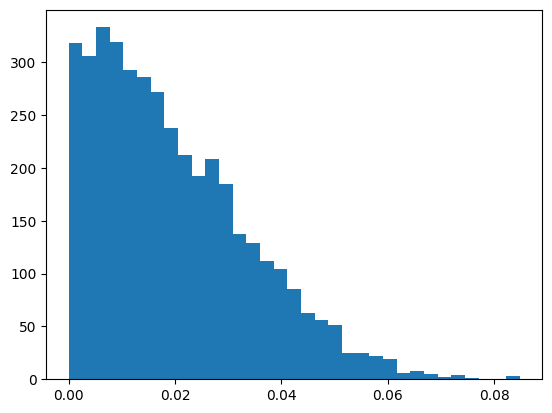

In [35]:
import matplotlib.pyplot as plt
activations_corr = np.abs(corr[0][1:])
_ = plt.hist(activations_corr, bins='auto')

In [58]:
activations_corr.shape

(4096,)

In [59]:
print(activations_corr)

[0.03559531 0.00085221 0.00096072 ... 0.03201354 0.02456037 0.05800861]


In [38]:
print(model.classifier)


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)


In [39]:
'''
def calculate_correlations(original_activations, patched_activations):
    # Convert activation lists to arrays
    original_activations_array = np.array([act[0] for act in original_activations])
    patched_activations_array = np.array([act[0] for act in patched_activations])

    # Ensure activations arrays have the correct shape
    original_activations_array = original_activations_array.reshape(len(original_activations_array), -1)
    patched_activations_array = patched_activations_array.reshape(len(patched_activations_array), -1)

    # Calculate correlations
    correlations = np.corrcoef(original_activations_array.T, patched_activations_array.T)

    # Extract correlations for each neuron
    neuron_correlations = correlations[:4096, 4096:]

    return neuron_correlations


# Extract activations for original and patched MAL images
#original_activations = preprocess_and_extract_activations(test_dataset)
#patched_activations = preprocess_and_extract_activations(test_patch_dataset)

# Define the folder paths containing the original and patched images
original_folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/malignant_nopatch_224"
patched_folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/malignant_patched_224"

# Extract activations for all images in the original and patched folders
original_activations = preprocess_and_extract_activations(original_folder_path)
patched_activations = preprocess_and_extract_activations(patched_folder_path)

# Calculate correlations for each neuron
neuron_correlations = calculate_correlations(original_activations, patched_activations)

# Print correlations for the first neuron as an example
print("Correlations for the first neuron:", neuron_correlations[0])
'''

'\ndef calculate_correlations(original_activations, patched_activations):\n    # Convert activation lists to arrays\n    original_activations_array = np.array([act[0] for act in original_activations])\n    patched_activations_array = np.array([act[0] for act in patched_activations])\n\n    # Ensure activations arrays have the correct shape\n    original_activations_array = original_activations_array.reshape(len(original_activations_array), -1)\n    patched_activations_array = patched_activations_array.reshape(len(patched_activations_array), -1)\n\n    # Calculate correlations\n    correlations = np.corrcoef(original_activations_array.T, patched_activations_array.T)\n\n    # Extract correlations for each neuron\n    neuron_correlations = correlations[:4096, 4096:]\n\n    return neuron_correlations\n\n\n# Extract activations for original and patched MAL images\n#original_activations = preprocess_and_extract_activations(test_dataset)\n#patched_activations = preprocess_and_extract_activati

In [41]:
stophere

NameError: name 'stophere' is not defined

## Archive

In [ ]:
# Load pre-trained VGG19 model
#model = models.vgg16(pretrained=True)

# Print the model architecture
#print(model)

In [ ]:
'''
def extract_activations(model, dataset):
    activations = []
    model.eval()
    with torch.no_grad():
        for inputs, _ in dataset:
            inputs = inputs.to(device)
            outputs = model[0](inputs)  # Pass through the convolutional layers only
            outputs = torch.flatten(outputs, 1)  # Flatten the output tensor
            outputs = model[2](outputs)  # Pass through the linear layers
            activations.append(outputs.cpu().numpy())  # Append activation
            print("Activation size:", outputs.shape)  # Print activation size
    return activations
'''

In [ ]:
'''
# Function to extract activations from images
def extract_activations(model, dataset):
    activations = []
    model.eval()
    with torch.no_grad():
        for inputs, _ in dataset:
            inputs = inputs.to(device)
            outputs = model(inputs)
            activations.append(outputs.squeeze().cpu().numpy())
            print("Activation size:", outputs.shape)  # Append activation
    return activations
'''

In [ ]:
'''
# Assuming 'patches' is a vector indicating whether patches were present or not for each image (length of 2N)
patches = np.array([0]*len(test_dataset) + [1]*len(test_patch_dataset))

print('patches', patches.shape)

# Assuming 'model' is the pre-trained model and 'test_dataset' and 'test_patch_dataset' are the original and patched image datasets
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Move the model to the same device as the input data
model.to(device)

# Assuming 'test_dataset' and 'test_patch_dataset' are concatenated together
original_activations = extract_activations(model, test_dataset)
patched_activations = extract_activations(model, test_patch_dataset)

# Split activations into two arrays based on patches
original_activations = np.array(original_activations[:len(test_dataset)])
patched_activations = np.array(patched_activations[len(test_dataset):])

print("Original activations shape:", original_activations.shape)
print("Patched activations shape:", patched_activations.shape)



#first_5_entries = original_activations[:5]
#print(first_5_entries)
'''

In [ ]:
#print(original_activations)

variant 2

In [ ]:
'''
# Load pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# Define the layer index you want to access
layer_index = 3

# Access the desired layer
target_layer = model.classifier[layer_index]

print(target_layer)
'''

In [ ]:

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os

# Load pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# Modify the classifier
model.classifier[-1] = torch.nn.Linear(4096, 2)

# Load the saved parameters into the model
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/models/initial_classifier/20240415115229.pt"
model.classifier.load_state_dict(torch.load(saved_model_path))

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to preprocess an image and extract activations
def preprocess_and_extract_activations(image_path):
    # Load and preprocess the image
    image = Image.open(image_path)
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    # Flatten the tensor before passing it to the linear layers
    image_tensor = model.features(image_tensor)
    image_tensor = model.avgpool(image_tensor)
    image_tensor = torch.flatten(image_tensor, 1)  # Flatten the tensor
    print("Flattened tensor shape:", image_tensor.shape)
    # Extract activations from the first to the fourth linear layer
    activations = []
    for layer_idx, layer in enumerate(model.classifier[:6], start=1):  # Slicing to access layers 0 to 5
        image_tensor = layer(image_tensor)
        activations.append(image_tensor.squeeze().cpu().detach().numpy())
        print(f"Activation {layer_idx} size:", activations[-1].shape)

        '''
    for layer_idx, layer in enumerate(model.classifier[:6], start=1):  # Slicing to access layers 0 to 5
        image_tensor = layer(image_tensor)
        activations.append(image_tensor.squeeze().cpu().detach().numpy())
        print(f"Activation {layer_idx} size:", activations[-1].shape)  # Print size of current activation
        '''

    return activations

# Function to recursively traverse folders and process images
def process_images_in_folder(folder_path):
    all_activations = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg')):
                image_path = os.path.join(root, file)
                activations = preprocess_and_extract_activations(image_path)
                if activations is not None:
                    all_activations.append(activations)
    return all_activations

# Folder path containing the images
folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/malignant_patched_224"

# Extract activations for all images in the folder
all_activations = process_images_in_folder(folder_path)

# Now you can use all_activations for further analysis, such as classification or visualization


In [ ]:
'''
results_file_path = oj(dir_path, "auc_f1_224_malig_patch.txt")
print(results_file_path)
with open(results_file_path, 'w') as f:
    f.write('AUC: ' + str(auc) + "\n")
    f.write('F1: ' + str(f1) + "\n")
'''

In [ ]:
#print("Flattened tensor shape:", image_tensor.shape)


In [ ]:
'''
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os

# Load pre-trained VGG16 model
model = models.vgg16(pretrained=True)
# Modify the last linear layer to match the output size of the loaded state dictionary
model.classifier[-1] = torch.nn.Linear(4096, 2) # Load the saved parameters into the model
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/models/initial_classifier/20240415115229.pt"
#model.classifier.load_state_dict(torch.load(saved_model_path))

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


# Define preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to preprocess an image and extract activations
# Function to preprocess an image and extract activations
def preprocess_and_extract_activations(image_path):
    # Load and preprocess the image
    image = Image.open(image_path)
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    # Flatten the tensor before passing it to the linear layers
    image_tensor = model.features(image_tensor)
    image_tensor = model.avgpool(image_tensor)
    image_tensor = torch.flatten(image_tensor, 1)  # Flatten the tensor

    # Extract activations from the last linear layer before the classification layer
    activations = model.classifier[-3](image_tensor)

    return activations.squeeze().cpu().detach().numpy()

# Function to recursively traverse folders and process images
def process_images_in_folder(folder_path):
    all_activations = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg')):
                image_path = os.path.join(root, file)
                activations = preprocess_and_extract_activations(image_path)
                if activations is not None:
                    all_activations.append(activations)
    return all_activations

# Folder path containing the images
folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/ISIC_224/malignant_patched_224"

# Extract activations for all images in the folder
all_activations = process_images_in_folder(folder_path)

# Now you can use all_activations for further analysis, such as classification or visualization
'''